In [67]:
###
# STAT 665 - HW 09
# Keyang Dong (kd538)
###

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import scale
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
#####
# PART - I : Create target value column & transform data
#####

X_train = pd.read_csv('yelp_train.csv')
X_test = pd.read_csv('yelp_test.csv')
predictors = list(X_train.columns)
predictors.remove('stars')
# target = 'positive'
y_train = np.array([int(v >= 4) for v in X_train['stars']])
y_test = np.array([int(v >= 4) for v in X_test['stars']])

# Transform column 'date' to timestamp format in integer type, so that temporal dynamic info can be better used
# divide (prescale) the timestamp to avoid numeric issue when scaling the whole dataset
dstr_to_timestamp = lambda s: int(datetime.strptime(s, "%Y-%m-%d").timestamp()) / 1000.0 
X_train['date'] = X_train['date'].apply(dstr_to_timestamp)
X_test['date'] = X_test['date'].apply(dstr_to_timestamp)

# Scale the data for better performance
X_train = DataFrame(scale(X_train.loc[:, predictors]), columns = predictors)
X_test = DataFrame(scale(X_test.loc[:, predictors]), columns = predictors)

n_col = len(predictors)  # after stripping 'stars' it's now 14

In [85]:
#####
# PART - II : Model Training & Model Selection
#####

def pre_tuning_plot(f_scores, clf, parameter, rng, scoring):
    """
    General purpose function for figuring out optimal selection 
    of features against certain classifier & certain parameter settings.
    The function sort all available predictors according to some pre-calculated scoring 
    between each predictor and target value (descendingly),
    and then plot scores in each parameter setting as a separate line.
    
    Args:
        f_scores: 1-d array-like of float
        clf: sklearn classifier object
        parameter: str of param name in clf class
        rng: list[float], range of the tuning parameter
        scoring: str of feature ranking method
    """
    
    ranked_features = [pname for pname, _ in sorted(zip(predictors, f_scores), 
                        key=lambda x: x[1], reverse=True)]
    opt_n_feature, opt_f1 = 0, 0.0
    plt.subplot(111)
    plt.title('Scoring: ' + scoring + '; Legend:' + parameter)
    plt.xlabel('n_features')
    plt.ylabel('F1-score')
    color_list = ['c', 'm', 'b', 'r']
    
    for param, color in zip(rng, color_list):
        clf.__dict__[parameter] = param
        scores = []
        for n_f in range(1, n_col+1):
            columns = ranked_features[:n_f]
            sc = cross_val_score(clf, X_train.loc[:, columns], y_train, scoring='f1', cv=5).mean()
            scores.append(sc)
            if sc > opt_f1:
                opt_n_feature, opt_f1 = n_f, sc
        plt.plot(range(1, n_col+1), scores, color, linewidth=1.5, label=param)
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    print('\nOptimal n_feature = {:d}, optimal F1 = {:f}'.format(opt_n_feature, opt_f1))
    print('\nPredictors\' Rank:\n', ranked_features)

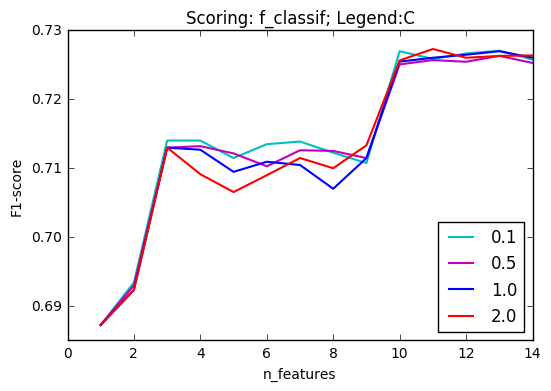


Optimal n_feature = 11, optimal F1 = 0.727295

Predictors' Rank:
 ['biz_stars', 'user_average_stars', 'words', 'characters', 'biz_review_count', 'funny', 'biz_open', 'useful', 'user_review_count', 'cool', 'user_useful', 'user_cool', 'user_funny', 'date']


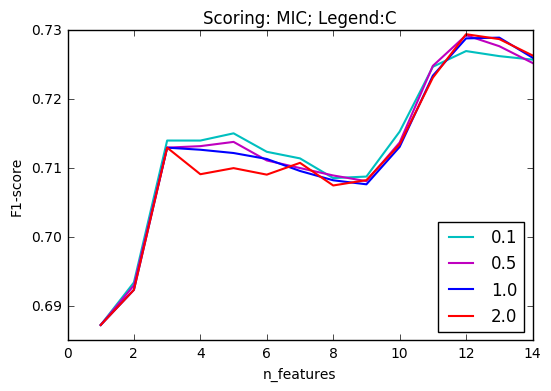


Optimal n_feature = 12, optimal F1 = 0.729441

Predictors' Rank:
 ['biz_stars', 'user_average_stars', 'words', 'characters', 'user_useful', 'user_funny', 'user_review_count', 'date', 'user_cool', 'cool', 'funny', 'useful', 'biz_review_count', 'biz_open']


In [47]:
# PART - 2.1 : Linear Regression
# ==============================

# For each possible C value in logistic regression model, 
# do feature selection separately and plot the corresponding f1-scores.
# For classification task we having 3 scoring functions: 
#     f_classif (F-value), chi2(chi-square), mic (mutual information coefficients),
# while chi2 requires all values > 0, so only fval & mic are applicable.
Fval, pval = f_classif(X_train, y_train)
pre_tuning_plot(Fval, LogisticRegression(), 'C', [0.1, 0.5, 1.0, 2.0], 'f_classif')
mic = mutual_info_classif(X_train, y_train)
pre_tuning_plot(mic, LogisticRegression(), 'C', [0.1, 0.5, 1.0, 2.0], 'MIC')

In [25]:
# From the above plots we can derive that:
# (1) The impact of feature selection on model performance is somewhat independent to setting of C;
# (2) The stability of trends derived from MIC is slightly better than that of F-value;
# (3) There are several crucial common features between plots of two methods, 
# by adding which to the training model the f1-score dramatically increases.

# So select the following features for training of an optimal LR model and test:
columns = ['biz_stars', 'user_average_stars', 'characters', 'words', 'cool']
# Now try to find optimal penalty coef C:
Cvals, scores = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0], []
for C in Cvals:
    clf = LogisticRegression(C=C)
    sc = cross_val_score(clf, X_train.loc[:, columns], y_train, scoring='f1', cv=5).mean()
    scores.append(sc)
print('(1.1) :\n', DataFrame({'C': Cvals, 'F1-score': scores}))

# Train the optimal LR model using C value obtained above:
opt_C = Cvals[scores.index(max(scores))]
lr = LogisticRegression(C=opt_C)
lr.fit(X_train.loc[:, columns], y_train)
f1_lr = f1_score(y_test, lr.predict(X_test.loc[:, columns]))
print('\n(1.2) F1-Score of Optimal Logistic Regression Model: {:.5f} with C={:f}'.format(f1_lr, opt_C))
print('\n(1.3) Feature Importances:\n', DataFrame({'Predictors': columns, 'Coef': lr.coef_[0]}))

#####
# Interpretation of Logistic Regression coefficients:
# The biz_stars & user_average_stars have positive correlation to target value,
# because they not only can indicate the quality of restaurant, also can lead the reviewer's attitudes.
# Meanwhile, wordy comments are usually complaining something bad about a business,
# leading to negative correlation between characters & words - target value.
# Moreover, compliments such as cool, funny often appear on a review with joyful expression (higher rating),
# also causes a positive coefficient to be reasonable.
#####

(1.1) :
       C  F1-score
0  0.01  0.719489
1  0.02  0.718077
2  0.05  0.717713
3  0.10  0.715907
4  0.20  0.715707
5  0.50  0.715277
6  1.00  0.714469
7  2.00  0.715522

(1.2) F1-Score of Optimal Logistic Regression Model: 0.69238 with C=0.010000

(1.3) Feature Importances:
        Coef          Predictors
0  0.851284           biz_stars
1  0.293605  user_average_stars
2 -0.145322          characters
3 -0.208571               words
4  0.142839                cool


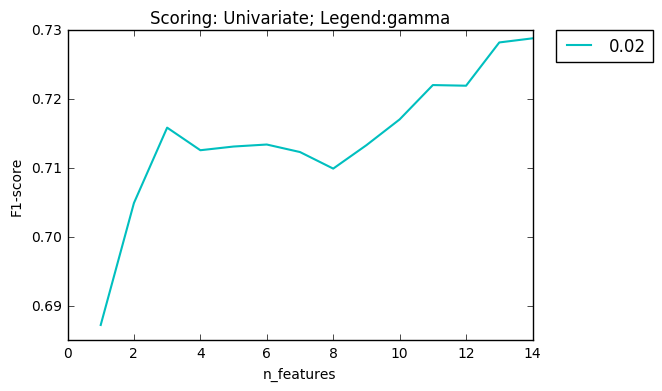


Optimal n_feature = 14, optimal F1 = 0.728842

Predictors' Rank:
 ['biz_stars', 'user_average_stars', 'characters', 'words', 'user_useful', 'date', 'biz_review_count', 'user_review_count', 'biz_open', 'cool', 'funny', 'user_cool', 'useful', 'user_funny']


In [87]:
# PART - 2.2 : Support Vector Machine Classifier (SVC)
# ===========================

# As SVM can exploit more complex & nonlinear correlation between features, 
# try using univariate feature selection (based on MIC) to rank predictors seems more reliable.
selector = SelectKBest(mutual_info_classif, 14)
selector.fit(X_train, y_train)
uni = selector.scores_
# Do pre-plot of features against parameter 'gamma' for each kernel (except linear)

# PART - 2.2.1 : Pre-tuning / Linear Kernel
pre_tuning_plot(uni, SVC(kernel='linear'), 'gamma', [0.02], 'Univariate')

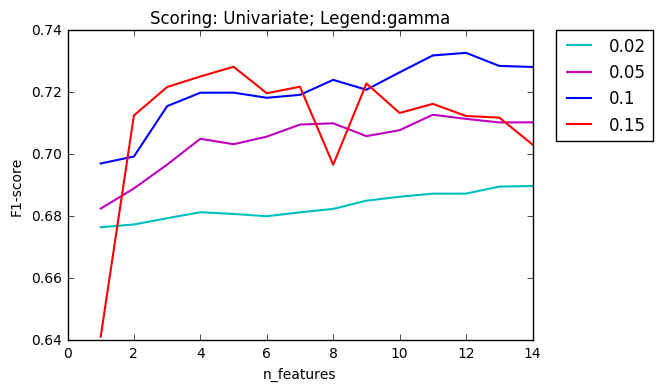


Optimal n_feature = 12, optimal F1 = 0.732745

Predictors' Rank:
 ['biz_stars', 'user_average_stars', 'characters', 'words', 'user_useful', 'date', 'biz_review_count', 'user_review_count', 'biz_open', 'cool', 'funny', 'user_cool', 'useful', 'user_funny']


In [88]:
# PART - 2.2.2 : Pre-tuning / Polynomial Kernel (n=3)
# It's clear that optimal gamma value falls between [0.1, 0.15), with 0.15 overfits.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pre_tuning_plot(uni, SVC(kernel='poly', tol=1e-3), 'gamma', [0.02, 0.05, 0.1, 0.15], 'Univariate')

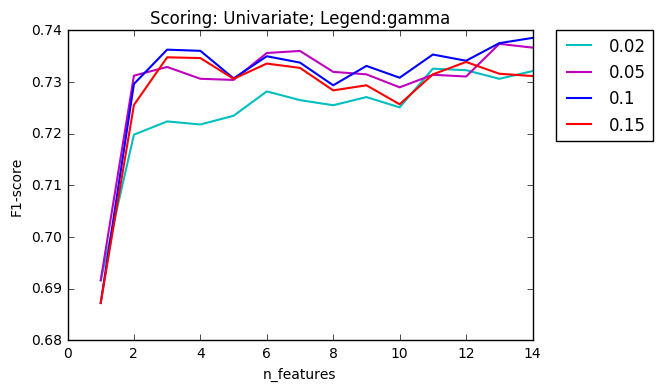


Optimal n_feature = 14, optimal F1 = 0.738540

Predictors' Rank:
 ['biz_stars', 'user_average_stars', 'characters', 'words', 'user_useful', 'date', 'biz_review_count', 'user_review_count', 'biz_open', 'cool', 'funny', 'user_cool', 'useful', 'user_funny']


In [89]:
# PART - 2.2.3 : Pre-tuning / RBF Kernel
# It's clear that optimal gamma value falls between [0.05, 0.15), with 0.15 overfits.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pre_tuning_plot(uni, SVC(kernel='rbf', tol=1e-3), 'gamma', [0.02, 0.05, 0.10, 0.15], 'Univariate')

In [90]:
def param_tuning(cols, clf, param_legend, range_legend, param_x, range_x):
    """
    General purpose function for figuring out optimal settings of two parameters. 
    In other words, it performs grid search in a form of line plots.
    
    Args:
        cols: List[str] of selected features
        clf: sklearn classifier object
        param_legend: str of param name to appear as separate lines
        range_legend: list[float], range of param_legend being tuned
        param_x: str of param name to appear on X-axis
        range_x: list[float], range of param_x being tuned
    """
    color_list = ['c', 'm', 'b', 'r']
    # opt_f1 = 0.0
    plt.subplot(111)
    plt.title('Kernel: ' + clf.__dict__['kernel'] + '; Legend:' + param_legend)
    plt.xlabel(param_x)
    plt.ylabel('F1-score')
    for p1, color in zip(range_legend, color_list):
        clf.__dict__[param_legend] = p1
        scores = []
        for p2 in range_x:
            clf.__dict__[param_x] = p2
            sc = cross_val_score(clf, X_train.loc[:, cols], y_train, scoring='f1', cv=5).mean()
            scores.append(sc)
#             if sc > opt_f1:
#                 opt_n_feature, opt_f1 = n_f, sc
        plt.plot(range_x, scores, color, linewidth=1.5, label=str(p1))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

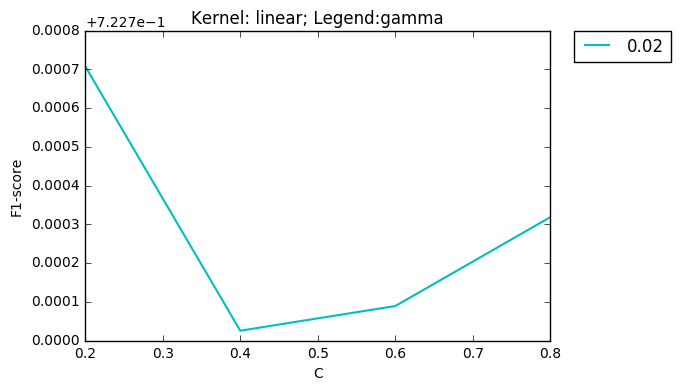

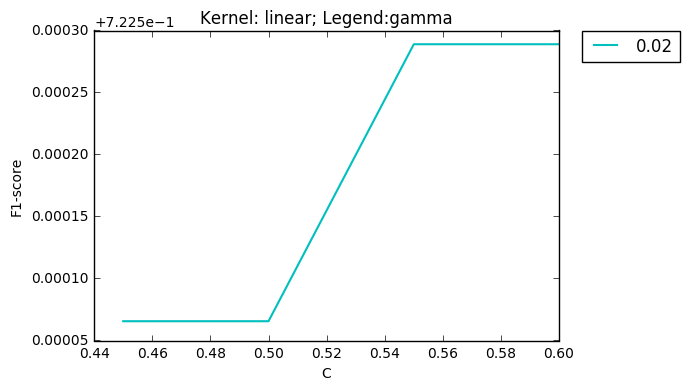

In [95]:
# PART - 2.2.4 : GridSearch / Linear Kernel
# Actually there is only one crucial parameter to set for linear kernel: regularization coef C.
# By looking into plot 2.2.1, we collect all features that causes a precision promotion as 'linear_cols',
# and tune the parameter using these features.
linear_cols = ['biz_stars', 'user_average_stars', 'characters', 'user_review_count', 'biz_open', 'cool', 'useful']
range_legend, range_x = [0.02], [0.2, 0.4, 0.6, 0.8]
param_tuning(linear_cols, SVC(kernel='linear'), 'gamma', range_legend, 'C', range_x)
range_x = [0.45, 0.5, 0.55, 0.6]
param_tuning(linear_cols, SVC(kernel='linear'), 'gamma', range_legend, 'C', range_x)

# It is clear that optimal C for linear kernel is around 0.55,
# Achieving f1~= 0.7228.

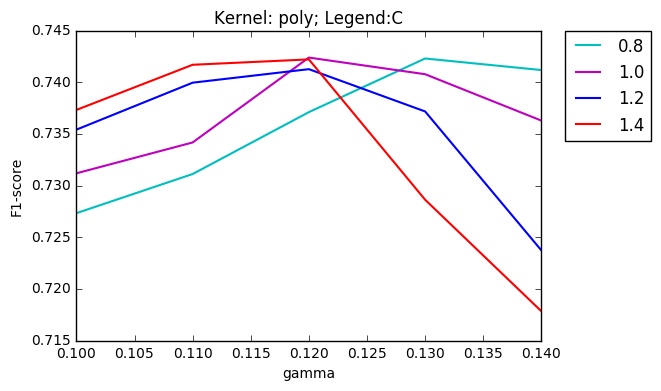

In [103]:
# PART - 2.2.5 : GridSearch / Polynomial Kernel (n=3)
# Perform grid search of parameters: C & gamma
poly_cols = ['biz_stars', 'user_average_stars', 'characters', 'words', 'user_review_count', 'cool', 'funny']
range_legend, range_x = [0.8, 1.0, 1.2, 1.4], [0.10, 0.11, 0.12, 0.13, 0.14]
param_tuning(poly_cols, SVC(kernel='poly', tol=1e-3), 'C', range_legend, 'gamma', range_x)

# Optimal parameters for poly kernel : C=0.8, gamma=0.13.
# Achieving f1~= 0.7425.

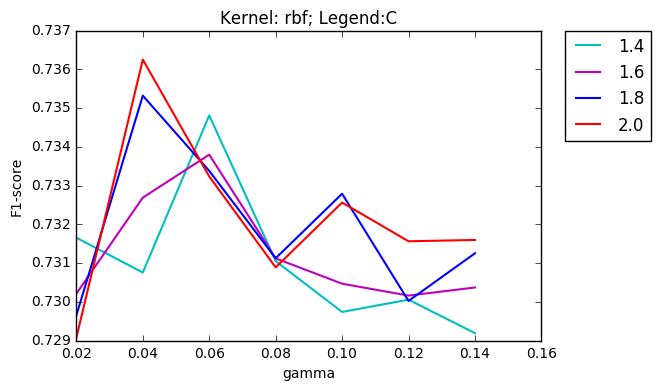

In [109]:
# PART - 2.2.6 : GridSearch / RBF Kernel
# Perform grid search of parameters: C & gamma
rbf_cols = ['biz_stars', 'user_average_stars', 'characters', 'date', 'biz_open', 'funny', 'useful', 'user_funny']
range_legend, range_x = [1.4, 1.6, 1.8, 2.0], [0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14]
param_tuning(rbf_cols, SVC(kernel='rbf', tol=1e-3), 'C', range_legend, 'gamma', range_x)

# Optimal parameters for radian kernel : C=2.0, gamma=0.04.
# Achieving f1~= 0.7362.

In [119]:
# PART 2.2.7 : Compare & Train Optimal SVM classifier
def summary_svc(cols, k, c, g='auto'):
    clf = SVC(kernel=k, tol=1e-3, C=c, gamma=g)
    clf.fit(X_train.loc[:, cols], y_train)
    f1 = f1_score(y_test, clf.predict(X_test.loc[:, cols]))
    print('\n\nF1-Score of Optimal {:s} SVC: {:.5f}'.format(k, f1))
    print('\nFeature selected:', cols)
    # print('\nFeature Importances:\n', DataFrame({'Predictors': cols, 'Coef': clf.coef_[0]}))

summary_svc(linear_cols, 'linear', 0.55)
summary_svc(poly_cols, 'poly', 0.8, 0.13)
summary_svc(rbf_cols, 'rbf', 2.0, 0.04)

# As can be seen, polynomial kernel performs best when doing training & cross-validation, 
# yet RBF kernel has better ability of generalizing to unseen test data.



F1-Score of Optimal linear SVC: 0.68986

Feature selected: ['biz_stars', 'user_average_stars', 'characters', 'user_review_count', 'biz_open', 'cool', 'useful']


F1-Score of Optimal poly SVC: 0.70266

Feature selected: ['biz_stars', 'user_average_stars', 'characters', 'words', 'user_review_count', 'cool', 'funny']


F1-Score of Optimal rbf SVC: 0.71967

Feature selected: ['biz_stars', 'user_average_stars', 'characters', 'date', 'biz_open', 'funny', 'useful', 'user_funny']
